# Cajamar Challenge: Data Processing, Model and Results

Author: Florent Micand

In [20]:
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from pandas import to_datetime
from keras.models import Model
from keras.layers import Dense, LSTM, Input
from keras.layers.merge import concatenate
from keras.preprocessing import sequence
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from nltk.util import skipgrams
import scipy.sparse as sp
from matplotlib import pyplot

%matplotlib inline

### 1. Data Processing

###### Importing data and simple modifications

In [5]:
#Importing the dataset
df = pd.read_csv('train2.txt', sep = '|')

In [6]:
# We discart gender
df.drop("Socio_Demo_04", axis=1, inplace = True)

# We substract 1 to some sociodemographic features, so they start in 0 (needed to use to_categorical later)
df.loc[:,"Socio_Demo_01"] = df.loc[:,"Socio_Demo_01"]-1
df.loc[:,"Socio_Demo_02"] = df.loc[:,"Socio_Demo_02"]-1
df.loc[:,"Socio_Demo_03"] = df.loc[:,"Socio_Demo_03"]-1

# We discart customers who have purchased once only
print(str(df.shape[0] - df[df["ID_Customer"].duplicated(keep = False)].shape[0])+" entries removed over "+str(df.shape[0]))
df = df[df["ID_Customer"].duplicated(keep = False)]

#We have a look at the data
df.sort_values('ID_Customer',ascending = True).head()

73497 entries removed over 3350601


,ID_Customer,Cod_Prod,Cod_Fecha,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_05
0,A0000001,601,2007-05,4,3,2,0
1,A0000001,704,2013-04,4,3,2,0
2,A0000001,2501,2006-03,4,3,2,0
3,A0000001,2503,2006-03,4,3,2,0
4,A0000001,1011,2011-04,4,3,2,0


###### Grouping data per user

In [7]:
#Getting the list of products not purchased in the last year, to be applied later
def products_no_purchased_recently(df,_days):
    
    # Most recent purchase date
    maxi = to_datetime(max(df["Cod_Fecha"]),format='%Y-%m')
    
    # Establishing a limit: _days from most recent purchase date
    limit = maxi - timedelta(days=_days)
    
    # We keep the most recent purchased for each product
    products_date=df.sort_values(by=["Cod_Prod", "Cod_Fecha"], ascending=[True,False])
    products_newest_date=products_date.drop_duplicates("Cod_Prod")
    
    # We check if those purchases were done before the limit
    products_no_purchased_recently = products_newest_date[to_datetime(products_newest_date["Cod_Fecha"],format='%Y-%m')<limit]["Cod_Prod"].values
    print("Number of products not purchased in the last "+str(_days)+" days: "+str(len(products_no_purchased_recently)))
    print(products_no_purchased_recently)
    return products_no_purchased_recently

In [8]:
#Grouping data per user
def grouping_df_per_user(df):
    
    #Creating auxiliary dataframe to work with.
    time1=time.time()
    df_aux = df.sort_values(by=["ID_Customer", "Cod_Fecha"], ascending=[True,True])
    
    #Dataframe 1: Customers list
    df1 = df_aux.drop_duplicates("ID_Customer", keep = "last").reset_index(drop=True)
    df1.drop("Cod_Fecha", axis=1, inplace=True)
    df1.rename(columns = {'Cod_Prod':'Last_Prod'}, inplace = True)

    #Dataframe 2: Products and purchase dates (months and years) lists 
    df2 = df_aux
    df2.drop(df2.columns[[3,4,5,6]], axis=1, inplace=True)
    df2["Cod_Month"] = to_datetime(df2["Cod_Fecha"],format='%Y-%m').dt.month
    df2["Cod_Year"] = to_datetime(df2["Cod_Fecha"],format='%Y-%m').dt.year
    df2.drop("Cod_Fecha", axis=1, inplace=True)
    df2 = df2.groupby("ID_Customer",sort=False,as_index=False).aggregate(lambda x: tuple(x))
    df2.loc[:,('Cod_Prod')] = df2.loc[:,('Cod_Prod')].map(lambda x: x[:-1])
    df2.loc[:,('Cod_Month')] = df2.loc[:,('Cod_Month')].map(lambda x: x[:-1])
    df2.loc[:,('Cod_Year')] = df2.loc[:,('Cod_Year')].map(lambda x: x[:-1])
    df2.columns = ['ID_Customer','Products','Months','Years']
    
    # Merging dataframes
    data=pd.merge(df1, df2, how='inner', on="ID_Customer")
    time2=time.time()
    
    #Removing customers which last product is one of the products not purchased in the last year
    old_products = products_no_purchased_recently(df,365)
    data2 = data[data['Last_Prod'].map(lambda x:x not in old_products)]
    print("Number of customers removed because of old last product: "+str(data.shape[0]-data2.shape[0]))
    
    #Removing some entries to have a dataset that can be divided easily to create train, test and valid subsets
    data2 = data2.iloc[:602040]
    print(time2-time1)
    return data2

data = grouping_df_per_user(df)
data.head()

Number of products not purchased in the last 365 days: 18
[ 104  502  504  702  703  705 1004 1007 1014 1015 1305 1312 1803 1806 2502
 2703 2801 3101]
Number of customers removed because of old last product: 807
99.70352172851562


,ID_Customer,Last_Prod,Socio_Demo_01,Socio_Demo_02,Socio_Demo_03,Socio_Demo_05,Products,Months,Years
0,A0000001,704,4,3,2,0,"(2501, 2503, 601, 1011)","(3, 3, 5, 4)","(2006, 2006, 2007, 2011)"
1,A0000002,9992,4,4,0,0,"(301, 601, 801)","(3, 6, 2)","(1995, 1998, 2006)"
2,A0000003,201,4,4,4,0,"(601, 2501, 2503, 301)","(11, 12, 12, 5)","(1985, 2011, 2011, 2012)"
3,A0000004,2301,4,4,2,0,"(601, 301, 201)","(5, 10, 12)","(2008, 2008, 2014)"
4,A0000005,601,4,4,2,0,"(301,)","(4,)","(1984,)"


###### Labels

In [9]:
#Creating the labels dataset to feed the model. 
#Encoding values and creating a binarized matrix class.
label_encoder = LabelEncoder().fit(pd.unique(data["Last_Prod"]))
y_encoded = label_encoder.transform(data["Last_Prod"].values)
y = np_utils.to_categorical(y_encoded)
print(y.shape)

(602040, 76)


###### Input 1: sequences of products, months, and years to feed the RNN part

In [12]:
# Sequencing products,months,years
max_prods=28
prod = sequence.pad_sequences(data["Products"].values,maxlen=max_prods)
months = sequence.pad_sequences(data["Months"].values,maxlen=max_prods)
years = sequence.pad_sequences(data["Years"].values,maxlen=max_prods)

# concatenate to have the RNN input in the way [samples, time steps, features]
X_rnn = np.concatenate((np.expand_dims(prod, axis=2), np.expand_dims(months, axis=2), np.expand_dims(years, axis=2)), axis=2)
print(X_rnn.shape)

(602040, 28, 3)


In [13]:
# Split the  dataset into training, validation and testing datasets.

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

def rnn_splitting(X,y,seed):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = seed)
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5, random_state = seed)    
    print(x_train.shape, x_test.shape, x_valid.shape, y_train.shape, y_test.shape, y_valid.shape )
    return x_train, x_test, x_valid, y_train, y_test, y_valid

X_rnn_train, X_rnn_test, X_rnn_valid, y_rnn_train, y_rnn_test, y_rnn_valid = rnn_splitting(X_rnn,y,seed)

(301020, 28, 3) (150510, 28, 3) (150510, 28, 3) (301020, 76) (150510, 76) (150510, 76)


###### Input 2 (called auxiliary input): Sociodemographic and skipgrams input to feed the dense part

In [14]:
# Considering age, seniority, incomes and activity sociodemographic features as categorical.
X_socio = np.empty([data.shape[0], 0])
for socio in data.columns.values[[2,3,4,5]]:
    new = np_utils.to_categorical(data[socio].values)
    X_socio = np.concatenate([X_socio,new],axis = 1)

print("Sociodemographic matrix shape:")
print(X_socio.shape)

Sociodemographic matrix shape:
(602040, 19)


In [15]:
#Creating products skipgrams

def skipgrams_generation(data,X_socio):
    
    #The higher sequence in the data is 28. That's why we can select 26 as the skip distance.
    time1=time.time()
    grams = []
    for sent in data["Products"].values:
        grams_sent = list(skipgrams(sent, 2, max_prods-2))
        grams.append(grams_sent)
        
    #Checking total number of different skipgrams
    todos = [val for sublist in grams for val in sublist]
    print("total number of skipgrams:")
    print(len(set(todos)))

    # Binarizing skipgrams
    mlb = MultiLabelBinarizer(sparse_output=True)
    binarized_grams=mlb.fit_transform(np.array(grams))
    print("skipgrams matrix shape:")
    print(binarized_grams.shape)

    # Concatenating binarized skipgrams to the dataset
    print("Auxiliary matrix shape:")
    X_socio_sparse=sp.csr_matrix(X_socio)
    X_aux=sp.hstack([X_socio_sparse,binarized_grams])
    print(X_aux.shape)
    
    #Checking for consistency, for instance taking the first entry
    print("Checking for consistency, printing the first matrix's entry and skipgrams obtained:")
    print(data["Products"].loc[0])
    print(grams[0])
    print(len(grams[0]))
    
    time2=time.time()
    print(time2-time1)
    return X_aux

X_aux = skipgrams_generation(data,X_socio)

total number of skipgrams:
6034
skipgrams matrix shape:
(602040, 6034)
Auxiliary matrix shape:
(602040, 6053)
Checking for consistency, printing the first matrix's entry and skipgrams obtained:
(2501, 2503, 601, 1011)
[(2501, 2503), (2501, 601), (2501, 1011), (2503, 601), (2503, 1011), (601, 1011)]
6
46.38507914543152


In [16]:
# Split the  dataset into training, validation and testing datasets.
def aux_splitting(X,y,seed):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = seed)
    x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5, random_state = seed)
    print(x_train.shape, x_test.shape, x_valid.shape, y_train.shape, y_test.shape, y_valid.shape )
    return x_train, x_test, x_valid, y_train, y_test, y_valid

X_aux_train, X_aux_test, X_aux_valid, y_aux_train, y_aux_test, y_aux_valid = aux_splitting(X_aux,y,seed)

(301020, 6053) (150510, 6053) (150510, 6053) (301020, 76) (150510, 76) (150510, 76)


### 2. Models: NN architectures, training, evaluation

###### Common functions

The code below is prepared for 3 different Neural Network architectures we want to explore, called "rnn_aux", "rnn" and "aux".

In [22]:
# Callback function to get metrics during batches processing 
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.loss = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

###### Neural Network architectures

In [23]:
# Neural Network architectures
def network(tipo,n_lstm,n_dense,printa = "no"):

    if tipo in ["rnn_aux","rnn"]:
        # input 1: meant to receive sequences of 28 integers
        main_input = Input(batch_shape=(_batch_size, X_rnn.shape[1], X_rnn.shape[2]), name='main_input')
        print("main input shape:")
        print(main_input.shape)

        # A LSTM will transform the vector sequences into a single vector, containing information about the entire sequence
        lstm_out = LSTM(n_lstm, stateful=True)(main_input)
        print("main input shape after LSTM:")
        print(lstm_out.shape)

    if tipo in ["rnn_aux","aux"]:
        #input 2: We consider the auxiliary input
        auxiliary_input = Input(batch_shape=(_batch_size, X_aux.shape[1]), name='aux_input')
        print("Auxiliary input shape:")
        print(auxiliary_input.shape)

    if tipo == "rnn_aux":
        # We concatenate the output of the lstm with the auxiliary input
        x = concatenate([lstm_out,auxiliary_input], axis = 1)
        print("concatenated input shape:")
        print(x.shape)
    elif tipo == "aux":
        x = auxiliary_input
    elif tipo == "rnn":
        x = lstm_out

    # We stack a deep densely-connected network on top
    x = Dense(n_dense, activation='relu')(x)
    x = Dense(int(n_dense/2), activation='relu')(x)

    # We add the main softmax classification layer
    main_output = Dense(y.shape[1], activation='softmax', name='main_output')(x)

    # We define the model object
    if tipo == "rnn_aux":
        model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])
    if tipo == "aux":
        model = Model(inputs=[auxiliary_input], outputs=[main_output])
    if tipo == "rnn":
        model = Model(inputs=[main_input], outputs=[main_output])

    #We compile the model
    model.compile(optimizer='adam',
                  loss={'main_output': 'categorical_crossentropy'},
                  metrics=['accuracy'])
    if printa == "yes":
        print(model.summary())
    return model

###### Training

In [24]:
# As some data is sparse, we need to use a Generator to feed the network by batch
def generators(tipo, X_rnn_data, X_aux_data, y_data, batch_size,_steps_per_epoch):
    counter=0
    shuffle_index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(shuffle_index)
    
    if tipo in ["rnn_aux","rnn"]:
        X_rnn_data =  X_rnn_data[shuffle_index,:,:]
    if tipo in ["rnn_aux","aux"]:    
        X_aux_data =  X_aux_data[shuffle_index,:]
    y_data =  y_data[shuffle_index]
    
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        if tipo in ["rnn_aux","rnn"]:
            X_rnn_batch = X_rnn_data[index_batch,:,:]
        if tipo in ["rnn_aux","aux"]:    
            X_aux_batch = X_aux_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        
        if tipo == "rnn_aux":
            yield ({'main_input': X_rnn_batch, 'aux_input': X_aux_batch},{'main_output': y_batch})
        elif tipo == "aux":
            yield ({'aux_input': X_aux_batch},{'main_output': y_batch})
        elif tipo == "rnn":
            yield ({'main_input': X_rnn_batch},{'main_output': y_batch})
            
        if (counter < _steps_per_epoch):
            np.random.shuffle(shuffle_index)
            counter=0

In [28]:
# We train the model by batches and we apply some callback functions.
def train(tipo,model,_epochs):

    _steps_per_epoch_train = X_rnn_train.shape[0]/_batch_size
    _steps_per_epoch_valid = X_rnn_valid.shape[0]/_batch_size
    
    # Callback function to stop training when the validation accuracy doesn't improve
    early_stopping = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=1, verbose=0, mode='auto')
    # Callback function to get metrics during batches processing
    history = LossHistory()    
    
    History = model.fit_generator(generator=generators(tipo,X_rnn_train, X_aux_train, y_aux_train,_batch_size,_steps_per_epoch_train),
                    epochs=_epochs,
                    steps_per_epoch=_steps_per_epoch_train,
                    verbose=1,
                    validation_data = generators(tipo,X_rnn_valid, X_aux_valid, y_aux_valid,_batch_size,_steps_per_epoch_valid),
                    validation_steps = _steps_per_epoch_valid,
                    callbacks=[history,early_stopping])

    batch_train_loss = history.loss
    batch_accuracy = history.acc
    epoch_validation_loss = History.history.get('val_loss')
    epoch_validation_accuracy = History.history.get('val_acc')
    
    metrics = [batch_train_loss,batch_accuracy,epoch_validation_loss,epoch_validation_accuracy]
    
    return metrics

###### Evaluation

In [29]:
# Evaluating the model on the test dataset
def evaluation(tipo,model):
    _steps_per_epoch_test = X_rnn_test.shape[0]/_batch_size
    test_loss = model.evaluate_generator(generator=generators(tipo,X_rnn_test, X_aux_test, y_aux_test,_batch_size,_steps_per_epoch_test),
                                         steps = _steps_per_epoch_test) 
    print(model.metrics_names)
    print(test_loss)

###### Plotting metrics

In [30]:
# Function to plot easily the training and validation metrics, accuracy or loss
def plotting(metrics, metric_name, model_name):
    
    # Usage: 
    # metrics is the list of values from the train function
    # metrics_name can be "acc" or "loss" to plot accuracy or loss metrics respectively
    # model_name can be "rnn_aux", "rnn" or "aux"
    
    # Selecting the appropiate data
    title_name = metric_name
    if metric_name == "loss":
        train = metrics[0]
        valid = metrics[2]
    elif metric_name == "acc":
        train = metrics[1]
        valid = metrics[3]
        title_name = "accuracy"
    
    # Configuring the graph variables
    batches = len(train)
    train_x_axis = np.arange(batches)
    valid_x_axis = (batches/len(valid))*np.arange(len(valid))
    linewidth = 2
    train_linestyle = "b-"
    valid_linestyle = "g-"
    pyplot.plot(train_x_axis, train, train_linestyle, linewidth=linewidth, label=model_name+"_train_"+metric_name)
    pyplot.plot(valid_x_axis, valid, valid_linestyle, linewidth=linewidth, label=model_name+"_valid_"+metric_name)
    
    # Configuring some graph style features
    pyplot.grid()
    pyplot.legend()
    pyplot.title(title_name+" evolution")
    pyplot.xlabel("batches")
    pyplot.ylabel(metric_name)
    fig = pyplot.figure(figsize=(10, 10))
    pyplot.show()

### 3. Results

We make use of the previously defined functions to run the desired models.

###### "rnn_aux" model only

main input shape:
(1730, 28, 3)
main input shape after LSTM:
(1730, 128)
Auxiliary input shape:
(1730, 6053)
concatenated input shape:
(1730, 6181)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
main_input (InputLayer)          (1730, 28, 3)         0                                            
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (1730, 128)           67584       main_input[0][0]                 
____________________________________________________________________________________________________
aux_input (InputLayer)           (1730, 6053)          0                                            
____________________________________________________________________________________________________
concatenate_3 (Concatenate)      (1730, 6181

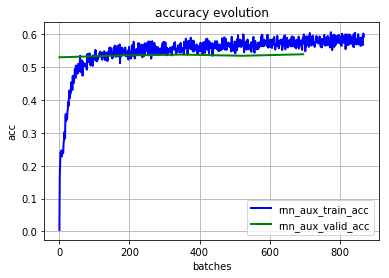

958.3856596946716


In [32]:
time1 = time.time()
_batch_size = 1730
all_epochs = 15
_tipo = "rnn_aux"
#usage: model(tipo, n_lstm, n_dense, printa)
model1 = network(_tipo, 128, 512, "yes")
metrics1 = train(_tipo, model1,all_epochs)
evaluation(_tipo, model1)
plotting(metrics1, "acc", _tipo)
print(time.time() - time1)

######  "rnn_aux" model: LSTM and Dense layers # Units Comparison

In [311]:
# Defining the function to plot the different results in one graph
def plotting_variants(all_metrics, metric_name):
    
    linewidth = 2
    pyplot.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    
    # Selecting the appropiate data
    model_names=["256_64","256_128","512_64","512_128"]
    i=0
    for metrics in all_metrics:
        model_name = model_names[i]
        title_name = metric_name
        if metric_name == "loss":
            train = metrics[0]
            valid = metrics[2]
        elif metric_name == "acc":
            train = metrics[1]
            valid = metrics[3]
            title_name = "accuracy"
            
        # Configuring the graph variables
        batches = len(train)
        train_x_axis = np.arange(batches)
        valid_x_axis = (batches/len(valid))*np.arange(len(valid))
                      
        #Linestyles definition
        if model_name == "256_64":
            train_linestyle = "r-"
            valid_linestyle = "r--"
        elif model_name == "256_128":
            train_linestyle = "g-"
            valid_linestyle = "g--"
        elif model_name == "512_64":
            train_linestyle = "b-"
            valid_linestyle = "b--"
        elif model_name == "512_128":
            train_linestyle = "y-"
            valid_linestyle = "y--"

        pyplot.plot(train_x_axis, train, train_linestyle, linewidth=linewidth, label=model_name+"_train_"+metric_name)
        pyplot.plot(valid_x_axis, valid, valid_linestyle, linewidth=linewidth, label=model_name+"_valid_"+metric_name)
    
        i=i+1
        
    # Configuring some graph style features
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("batches")
    pyplot.ylabel(metric_name)
    pyplot.show()

In [312]:
# Executing the 3 variants

time1 = time.time()
_batch_size = 1730
variants_metrics=[]
_tipo="rnn_aux"
all_epochs = 15
denses = [256,512]
lstms = [64,128]

for n_dense in denses:
    for n_lstm in lstms:
        #usage: model(tipo, n_lstm, n_dense, printa)
        model = network(_tipo, n_lstm, n_dense)
        metric = train(_tipo, model, all_epochs)
        evaluation(_tipo, model)
        variants_metrics.append(metric)
print(time.time() - time1)

main input shape:
(1730, 28, 3)
main input shape after LSTM:
(1730, 64)
Auxiliary input shape:
(1730, 6056)
concatenated input shape:
(1730, 6120)
Epoch 1/15
174/174 [==============================] - 342s - loss: 2.1499 - acc: 0.4421 - val_loss: 1.7170 - val_acc: 0.5270
Epoch 2/15
174/174 [==============================] - 128s - loss: 1.6316 - acc: 0.5447 - val_loss: 1.6637 - val_acc: 0.5341
Epoch 3/15
174/174 [==============================] - 136s - loss: 1.5725 - acc: 0.5568 - val_loss: 1.6455 - val_acc: 0.5370
Epoch 4/15
174/174 [==============================] - 132s - loss: 1.5363 - acc: 0.5630 - val_loss: 1.6336 - val_acc: 0.5378
Epoch 5/15
174/174 [==============================] - 131s - loss: 1.5083 - acc: 0.5701 - val_loss: 1.6341 - val_acc: 0.5376
['loss', 'acc']
[1.6381901160053822, 0.53749251571194878]
main input shape:
(1730, 28, 3)
main input shape after LSTM:
(1730, 128)
Auxiliary input shape:
(1730, 6056)
concatenated input shape:
(1730, 6184)
Epoch 1/15
174/174 [==

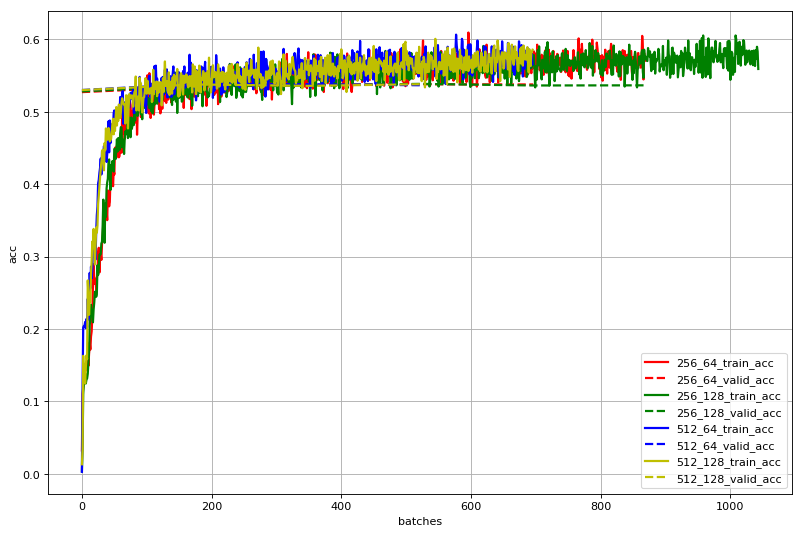

In [313]:
plotting_variants(variants_metrics, "acc")

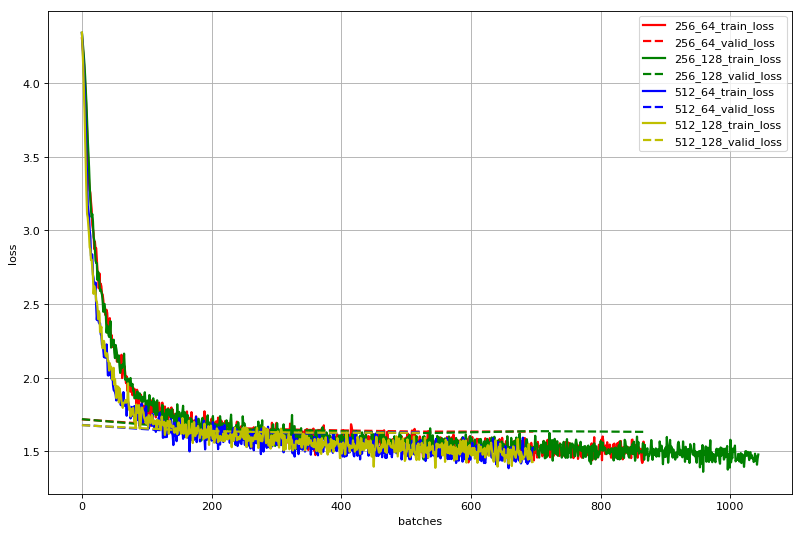

In [314]:
plotting_variants(variants_metrics, "loss")

###### "rnn_aux", "rnn", and "aux" models Comparison

In [23]:
# Defining the function to plot the different results in one graph
def plotting_all(all_metrics, metric_name):
    
    linewidth = 2
    pyplot.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
    
    # Selecting the appropiate data
    model_names=["rnn_dense","rnn","dense"]
    i=0
    for metrics in all_metrics:
        model_name = model_names[i]
        title_name = metric_name
        if metric_name == "loss":
            train = metrics[0]
            valid = metrics[2]
        elif metric_name == "acc":
            train = metrics[1]
            valid = metrics[3]
            title_name = "accuracy"
            
        # Configuring the graph variables
        batches = len(train)
        train_x_axis = np.arange(batches)
        valid_x_axis = (batches/len(valid))*np.arange(len(valid))
                      
        #Linestyles definition
        if model_name == "rnn_dense":
            train_linestyle = "r-"
            valid_linestyle = "r--"
        elif model_name == "dense":
            train_linestyle = "g-"
            valid_linestyle = "g--"
        elif model_name == "rnn":
            train_linestyle = "b-"
            valid_linestyle = "b--"

        pyplot.plot(train_x_axis, train, train_linestyle, linewidth=linewidth, label=model_name+"_train_"+metric_name)
        pyplot.plot(valid_x_axis, valid, valid_linestyle, linewidth=linewidth, label=model_name+"_valid_"+metric_name)
    
        i=i+1
        
    # Configuring some graph style features
    pyplot.grid()
    pyplot.legend()
    pyplot.xlabel("batches")
    pyplot.ylabel(metric_name)
    pyplot.show()

main input shape:
(1730, 28, 3)
main input shape after LSTM:
(1730, 64)
Auxiliary input shape:
(1730, 6053)
concatenated input shape:
(1730, 6117)
Epoch 1/15
174/174 [==============================] - 133s - loss: 1.9915 - acc: 0.4761 - val_loss: 1.6752 - val_acc: 0.5310
Epoch 2/15
174/174 [==============================] - 108s - loss: 1.5861 - acc: 0.5524 - val_loss: 1.6404 - val_acc: 0.5363
Epoch 3/15
174/174 [==============================] - 107s - loss: 1.5294 - acc: 0.5657 - val_loss: 1.6375 - val_acc: 0.5365
Epoch 4/15
174/174 [==============================] - 108s - loss: 1.4894 - acc: 0.5734 - val_loss: 1.6299 - val_acc: 0.5384
Epoch 5/15
174/174 [==============================] - 108s - loss: 1.4548 - acc: 0.5820 - val_loss: 1.6373 - val_acc: 0.5372
Epoch 6/15
174/174 [==============================] - 108s - loss: 1.4250 - acc: 0.5894 - val_loss: 1.6544 - val_acc: 0.5339
['loss', 'acc']
[1.664819525576186, 0.53494118410965497]
main input shape:
(1730, 28, 3)
main input sha

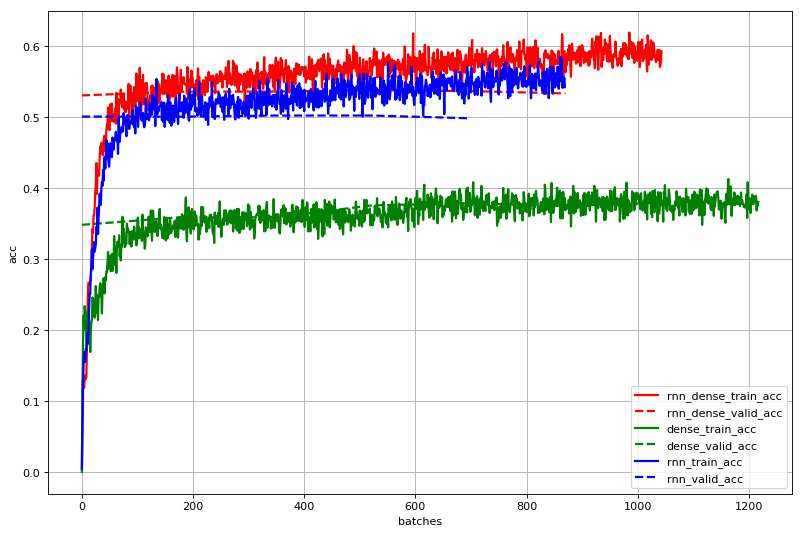

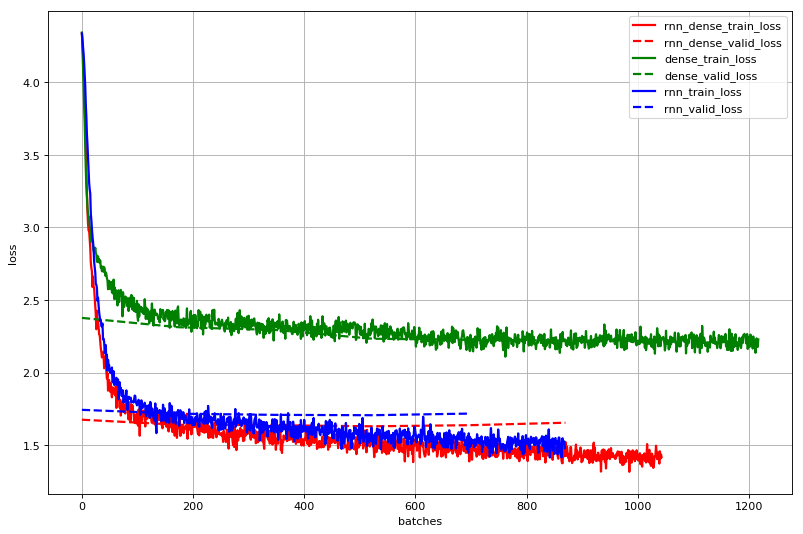

1391.084719657898


In [22]:
# Executing the 3 models

time1 = time.time()
_batch_size = 1730

all_metrics=[]
all_epochs = 15
tipos = ["rnn_aux","rnn","aux"]

for _tipo in tipos:
    #usage: model(tipo, n_lstm, n_dense, printa)
    model = network(_tipo, 64, 512)
    metric = train(_tipo, model, all_epochs)
    evaluation(_tipo, model)
    all_metrics.append(metric)
    
plotting_all(all_metrics, "acc")
plotting_all(all_metrics, "loss")
print(time.time() - time1)

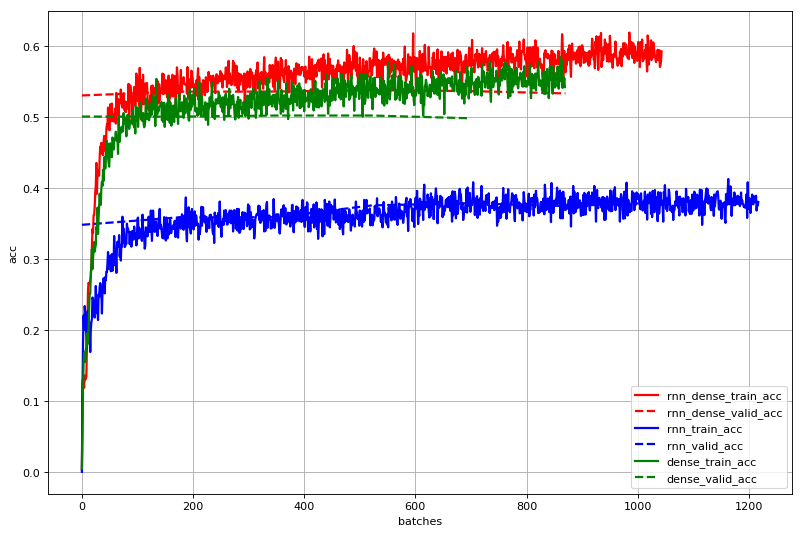

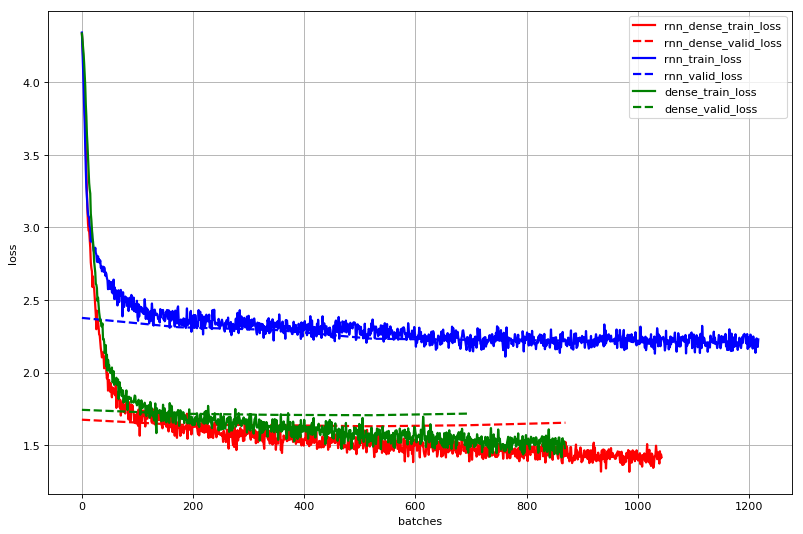

In [24]:
plotting_all(all_metrics, "acc")
plotting_all(all_metrics, "loss")

###### Extra: RNN part without the two denses layers

In [28]:
def rnn_no_denses(n_lstm,n_dense,printa = "no"):

    # input 1: meant to receive sequences of 28 integers
    main_input = Input(batch_shape=(_batch_size, X_rnn.shape[1], X_rnn.shape[2]), name='main_input')
    print("main input shape:")
    print(main_input.shape)

    # A LSTM will transform the vector sequences into a single vector, containing information about the entire sequence
    lstm_out = LSTM(n_lstm, stateful=True)(main_input)
    print("main input shape after LSTM:")
    print(lstm_out.shape)

    x = lstm_out

    # we add the main softmax classification layer
    main_output = Dense(y.shape[1], activation='softmax', name='main_output')(x)

    # This defines a model with two inputs and two outputs:
    model = Model(inputs=[main_input], outputs=[main_output])

    #We compile the model
    model.compile(optimizer='adam',
                  loss={'main_output': 'categorical_crossentropy'},
                  metrics=['accuracy'])
    if printa == "yes":
        print(model.summary())
    return model

In [30]:
# Executing the rnn without denses layers

time1 = time.time()
_batch_size = 1730
all_epochs = 15

model_rnn = rnn_no_denses(64,512)
metric_rnn = train("rnn", model_rnn, all_epochs)
evaluation("rnn", model_rnn)
plotting(metric_rnn, "acc")
plotting(metric_rnn, "loss")
print(time.time() - time1)

main input shape:
(1730, 28, 3)
main input shape after LSTM:
(1730, 64)
Epoch 1/15
174/174 [==============================] - 74s - loss: 3.2631 - acc: 0.1414 - val_loss: 2.8665 - val_acc: 0.1973
Epoch 2/15
174/174 [==============================] - 68s - loss: 2.7993 - acc: 0.2102 - val_loss: 2.7477 - val_acc: 0.2185
Epoch 3/15
174/174 [==============================] - 67s - loss: 2.7190 - acc: 0.2325 - val_loss: 2.6927 - val_acc: 0.2426
Epoch 4/15
174/174 [==============================] - 67s - loss: 2.6648 - acc: 0.2519 - val_loss: 2.6353 - val_acc: 0.2768
Epoch 5/15
174/174 [==============================] - 68s - loss: 2.6249 - acc: 0.2864 - val_loss: 2.5948 - val_acc: 0.2915
Epoch 6/15
174/174 [==============================] - 68s - loss: 2.5621 - acc: 0.3062 - val_loss: 2.5390 - val_acc: 0.3119
Epoch 7/15
174/174 [==============================] - 67s - loss: 2.5145 - acc: 0.3193 - val_loss: 2.4997 - val_acc: 0.3192
Epoch 8/15
174/174 [==============================] - 67s - 

TypeError: plotting() missing 1 required positional argument: 'model_name'

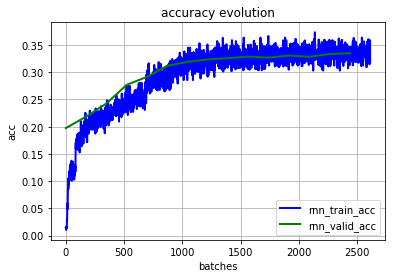

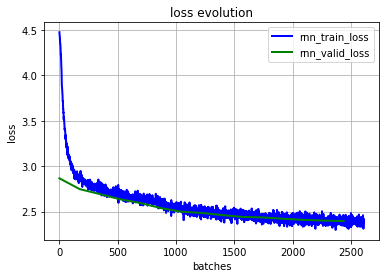

In [31]:
plotting(metric_rnn, "acc","rnn")
plotting(metric_rnn, "loss","rnn")